In [1]:
#https://github.com/zclaytor/kiauhoku/blob/master/notebooks/mcmc_offsets.ipynb
import numpy as np
import matplotlib.pyplot as plt
import kiauhoku as kh
import pandas as pd

In [4]:
#installing astropy created a numpy conflict that broke the whole kiauhoku2 environment. fuck. 
#trying in kiauhoku2b which cant find emcee for some reason
#pip uninstall numpypip uninstall numpy\

#scipy-1.7.3 (defaults/linux-64)
#+numpy-1.20.3 (defaults/linux-64)
#
# fixed kiauhoku2
#conda install -c conda-forge scipy=1.7.3 --no-deps
#pip install numpy==1.20.3 


In [2]:
#pip install kiauhoku

In [ ]:
# steal from https://github.com/zclaytor/kiauhoku/blob/main/notebooks/model_offsets.ipynb

In [2]:
rocrit = kh.load_interpolator('rocrit')

In [3]:
# use grid points between ZAMS (201) and RGBump (605)
qstring = '0.6 <= initial_mass <= 2.1 and -1.0 <= initial_met <= 0.5 and 201 <= eep <= 605'

# Whether to fit evolved metallicity (True) or use the initial metallicity.
# False is probably fine if you're not on the giant branch.
evolve_met = False

# load grid, remove unwanted rows
rocrit = kh.load_eep_grid("rocrit").query(qstring)
# set column names to some standard
rocrit['mass'] = rocrit['Mass(Msun)']
rocrit['teff'] = 10**rocrit['Log Teff(K)']
rocrit['lum'] = rocrit['L/Lsun'] #10**
if evolve_met:
    rocrit['met'] = np.log10(rocrit['Zsurf']/rocrit['Xsurf']/0.0253)
else:
    rocrit['met'] = rocrit.index.get_level_values('initial_met')
rocrit['age'] = rocrit['Age(Gyr)']
# set name for readability of output
rocrit.set_name('rocrit')
# cast to interpolator
rocrit =rocrit.to_interpolator()


In [4]:
def fit_all_grids(star, *args, **kwargs):
    gridnames = []
    models = []
    for gname, interp in zip(
        ['rocrit'],
        [rocrit]):
        model, fit = interp.gridsearch_fit(star, *args, **kwargs)
        if fit.success:
            gridnames.append(gname)
            models.append(
                model[['initial_mass', 'initial_met', 'eep', 'mass', 'teff', 'lum', 'met', 'logg', 'Prot(days)','age']]
            )
    models = pd.concat(models, axis=1)
    models.columns = gridnames

    return models

def compute_statistics(models, exclude=None):
    stats = models.copy()
    if exclude is not None:
        stats = stats.drop(columns=exclude)

    mean = stats.mean(axis=1)
    stdev = stats.std(axis=1, ddof=1)
    max_offset = stats.max(axis=1) - stats.min(axis=1)

    stats['mean'] = mean
    stats['stdev'] = stdev
    stats['max offset'] = max_offset

    return stats

In [5]:
sun3 = {'age': 4.57, 'mass':1, 'met':0}
models = fit_all_grids(sun3, scale=(1, 0.1, 0.1), tol=1e-6)
models

Fitting star with rocrit...
rocrit: success!


,rocrit
initial_mass,1.000000e+00
initial_met,-3.193749e-08
eep,3.316768e+02
mass,1.000000e+00
teff,5.815810e+03
lum,1.056234e+00
met,-3.193749e-08
logg,4.425904e+00
Prot(days),2.519027e+01
age,4.569999e+00


In [ ]:

stats = compute_statistics(models, exclude=None)
stats

In [ ]:
sun4 = {'logg': 4.438, 'mass':1, 'met':0}
models = fit_all_grids(sun4, scale=(.1, 0.1, 0.1), tol=1e-6)
models

In [ ]:
print(models.loc["Prot(days)"],models.loc["age"] )


In [ ]:
#okay given that i can do this fit for one star, can i read in the whole scvz sample and do that

In [ ]:
df = pd.read_table("/home/jtayar/Documents/TESS/SCVZglobalSeisMay2024bMassesEdit.txt", sep=r"[ ]{2,}", on_bad_lines='warn')

In [ ]:
df.seismicM

In [ ]:
good=np.where((df.seismicM>0) )
print(df.seismicM[good])

In [ ]:
#from AIPheGI6.ipynb


In [ ]:
#def yrec_iso(ages, metals):
#    masses=np.linspace(0.9,1.25,500) #[.9, .95, 1.0, 1.05, 1.1, 1.15, 1.20, 1.25]
#    gridnames = []
#    models = []
#    for i in range(len(masses)):
#        star={'age':ages, 'met':metals, 'mass':masses[i] }
#        model1=fit_yrec(star,scale=(0.1, 0.1, 0.1), tol=1e-6)
#        models.append(model1)
#        #models.columns = gridnames
#    models = pd.concat(models, axis=1)
#    models.columns = masses
#    return models

I think the quality 1 stars may be being fit as if they are seismic, when really we should fit them photometrically. fix!

In [ ]:
#set this up so that if it has a seismic mass, it fits M/seisLogg/feh
# and if it doesn't have a seismic mass, fit lum/teff/feh
# also use the salaris 1993 corrected metallicity
models = []
for i in range(len(df.seismicM)):
    if df.alfe[i] > -100:
        salcorr=df.fehgood[i]+df.alfe[i]*0.638
    if df.alfe[i] < -100: #becuase someone decided to store the nothing values as -9999
        salcorr=df.fehgood[i]
    star={'logg': df.seismiclogg[i], 'mass':df.seismicM[i], 'met':salcorr}
    if df.seismicM[i]> 2.0:
         star={'logg': df.seismiclogg[i], 'mass':1.99, 'met':salcorr}
    print(star)
    if df.seismicM[i] < 0: 
        print('no')
        star={'teff': df.teffphot[i], 'lum':df.Lphot[i], 'met':salcorr}
        model1=fit_all_grids(star, scale=(1000, 1.0, 0.1), tol=1e-6)
        models.append(model1)
    if df.seismicM[i] > 0:
        model1=fit_all_grids(star, scale=(.1, 0.1, 0.1), tol=1e-6)
        models.append(model1)
    
print(models)

In [ ]:
star1=np.array(models[0])
print(star1[0])


In [ ]:
fitstars=np.array(models)
massesfit=fitstars[:,3].reshape(-1)
agesfit=fitstars[:,9].reshape(-1)
rotfit=fitstars[:,8].reshape(-1)

print( np.array((np.squeeze(fitstars))).T)


In [ ]:
df['massfit'] = massesfit.tolist()
df

In [ ]:
df['Protfit'] = rotfit.tolist()
df['agefit'] = agesfit.tolist()

In [ ]:
df

In [ ]:
tefffit=fitstars[:,4].reshape(-1)
df['tefffit'] = tefffit.tolist()
lumfit=fitstars[:,5].reshape(-1)
df['lumfit'] = lumfit.tolist()
fehfit=fitstars[:,6].reshape(-1)
df['fehfit'] = fehfit.tolist()

In [ ]:
plt.scatter(df.teffphot, np.log10(df.Lphot), c=df.agefit, vmin=0, vmax=12,s=40)
plt.xlabel('Teff (Phot)')
plt.ylabel('Log (Luminosity/Lsun) (Phot)')
plt.colorbar(label='Age Fit')
#plt.text(14, 1.5, 'M4- APOGEE')
plt.xlim(7000,4000)
plt.ylim(-0.5, 1.7)

In [ ]:
#save to file
df.to_csv('TESSsubgiantsKHfit_insertdate.csv')


In [ ]:
good=df.where((abs(df.teffphot-df.tefffit)<10) #& ((df.Lphot-df.lumfit)<0.1)) 
              |(abs(df.seismicM-df.massfit)<0.1))
(good).teffphot

In [ ]:
good2=df.where(((df.teffphot-df.tefffit)<10) & (df.seismicM == -9999)) # |((df.seismicM-df.massfit)<0.1))

In [ ]:
good2

In [ ]:
df.teffphot-df.tefffit

In [ ]:
df.seismicM-df.massfit

In [ ]:
plt.scatter(good.teffphot, np.log10(good.Lphot), c=good.agefit, vmin=0, vmax=12,s=40)
plt.xlabel('Teff (Phot)')
plt.ylabel('Log (Luminosity/Lsun) (Phot)')
plt.colorbar(label='Age Fit')
#plt.text(14, 1.5, 'M4- APOGEE')
plt.xlim(7000,4000)
plt.ylim(-0.5, 1.7)

In [ ]:
plt.scatter(good.teffphot, np.log10(good.Lphot), c=good.Protfit, vmin=0, vmax=200,s=40)
plt.xlabel('Teff (Phot)')
plt.ylabel('Log (Luminosity/Lsun) (Phot)')
plt.colorbar(label='Prot Fit')
#plt.text(14, 1.5, 'M4- APOGEE')
plt.xlim(7000,4000)
plt.ylim(-0.5, 1.7)

In [ ]:
plt.scatter(good.teffphot, np.log10(good.Lphot), c=good.Psurf, vmin=0, vmax=100,s=40)
plt.xlabel('Teff (Phot)')
plt.ylabel('Log (Luminosity/Lsun) (Phot)')
plt.colorbar(label='Prot Obs')
#plt.text(14, 1.5, 'M4- APOGEE')
plt.xlim(7000,4000)
plt.ylim(-0.5, 1.7)

In [ ]:
#prove that we are only selecting stars with either a good seismic fit or a good teff fit
plt.scatter(good.teffphot-good.tefffit, good.seismicM-good.massfit, c=good.agefit, vmin=0, vmax=12,s=40)
plt.xlabel('Teff offset')
plt.ylabel('mass offset')
#plt.ylim(-1,1)
plt.colorbar(label='Age Fit')

In [ ]:
plt.scatter(good.Psurf, (good.Protfit), c=good.massfit, vmin=0.6, vmax=2,s=40)
plt.xlabel('Psurf (obs)')
plt.ylabel('Psurf (theory)')
plt.colorbar(label='Mass Fit')
plt.text(10, 175, 'faster than single star')
plt.text(175, 10, 'weird')
plt.plot([0,1000],[0,1000])
plt.xlim(0, 200)
plt.ylim(0,200)

In [ ]:
#pip install astropy
#no bad killed everything no

In [8]:
#switch to fits tables because i really don't undestand dataframes
#this was a total trap that broke my entire kiauhoku environment. bad hate no.

#from astropy.table import Table
#scvz=Table.read('TESSsubgiantsKHfit_2024June20.csv')

In [6]:
df = pd.read_table("TESSsubgiantsKHfit_2024June20.csv", sep=',')
df

,num,tic,numaxav,numaxerr,dnuav,dnuerr,teffphot,fehgood,speclogg,seismiclogg,...,nfe,alfe,binary,life,massfit,Protfit,agefit,tefffit,lumfit,fehfit
0,0,25117756,791.0410,79.104100,28.9337,2.893370,5151.0,0.104838,3.83286,-9999.00000,...,0.139310,-0.031537,0,-9999.0,1.349704,62.374631,3.765257,5150.999917,4.559999,0.084717
1,1,25156036,207.4330,0.510699,15.9212,0.151192,4652.0,0.219418,3.20518,3.21411,...,0.219820,0.005225,0,-9999.0,1.042030,763.575587,11.033657,4681.788755,7.582136,0.222752
2,2,30265037,582.2240,58.222400,43.7676,4.376760,4959.0,0.104498,3.66515,-9999.00000,...,0.168197,-0.015207,0,-9999.0,1.245031,142.671736,5.160992,4958.999545,4.349998,0.094796
3,3,30533103,-9999.0000,-9999.000000,-9999.0000,-9999.000000,5003.0,0.160478,3.56297,-9999.00000,...,0.207850,-0.035024,0,-9999.0,1.507908,66.939636,2.622257,5003.000469,6.560000,0.138133
4,4,31506424,408.7510,3.325110,28.7076,0.023238,5217.0,-0.549412,3.47928,3.53358,...,-0.126300,0.067149,0,-9999.0,1.013381,152.827985,7.405162,5174.622669,5.239984,-0.506571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,381976956,78.6713,0.299835,7.7018,0.140665,5022.0,-0.577122,2.86228,-9999.00000,...,0.118560,0.048593,0,-9999.0,1.292561,227.311005,3.204361,5021.999772,26.400000,-0.546119
116,116,382067256,274.2390,1.216670,19.2708,0.110203,4842.0,0.090000,3.37500,3.34405,...,-9999.000000,-9999.000000,0,-9999.0,1.251410,288.400412,5.199685,4849.710635,7.739184,0.090001
117,117,382101770,-9999.0000,-9999.000000,-9999.0000,-9999.000000,5327.0,-0.344572,3.70693,-9999.00000,...,-0.164100,0.052781,0,-9999.0,1.218945,51.693957,4.314783,5326.999614,5.530000,-0.310898
118,118,382159212,507.7820,15.557600,34.3976,0.086691,5233.0,-0.286000,3.68400,3.62846,...,-9999.000000,-9999.000000,0,-9999.0,0.947845,217.888809,11.261552,5025.292414,3.589782,-0.286000


In [ ]:
#oodfit=np.where(  (abs(scvz['teffphot']-scvz['tefffit'])<10)| (abs(scvz['seismicM']-scvz['massfit'])<0.1) )

In [7]:
m10=rocrit.get_track((1,0,0))
m12=rocrit.get_track((1.2,0,0))
m14=rocrit.get_track((1.4,0,0))
m16=rocrit.get_track((1.6,0,0))
m18=rocrit.get_track((1.8,0,0))
m20=rocrit.get_track((1.99,0,0))

In [ ]:
#plt.scatter(scvz['Psurf'][goodfit], scvz['Protfit'][goodfit], c=scvz['massfit'][goodfit], vmin=0.6, vmax=2,s=40)
#plt.xlabel('Psurf (obs)')
#plt.ylabel('Psurf (theory)')
#plt.colorbar(label='Mass Fit')
#plt.text(10, 175, 'faster than single star')
#plt.text(175, 10, 'weird')
#plt.plot([0,1000],[0,1000])
#plt.xlim(0, 200)
#plt.ylim(0,200)

In [9]:
Omcorarr=np.array(df.Omcore)
omcoreTc=1e-9*Omcorarr*2.*3.14159
PcoreTc=2.*3.14159/(60.*60.*24.*omcoreTc)
bad=np.where(Omcorarr <=0)
PcoreTc[bad]=-9999

In [11]:
from matplotlib import *

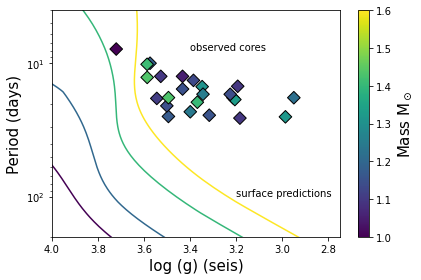

In [15]:
minm=1.0
maxm=1.6
plt.scatter( df.seismiclogg,PcoreTc, c=df.massfit, vmin=minm, vmax=maxm,s=80,
            marker='D', edgecolors='k', cmap='viridis')
#plt.scatter( scvz['seismiclogg'][goodfit],scvz['Protfit'][goodfit], c=scvz['massfit'][goodfit], marker='p',
#            vmin=1.0, vmax=1.6,s=10)
cmap=colormaps['viridis']
color=m10['mass'][300]
plt.plot(m10['logg'], m10['Prot(days)'], c=cmap((1.0-minm)/(maxm-minm)))
plt.plot(m12['logg'], m12['Prot(days)'], c=cmap((1.2-minm)/(maxm-minm)))
plt.plot(m14['logg'], m14['Prot(days)'], c=cmap((1.4-minm)/(maxm-minm)))
plt.plot(m16['logg'], m16['Prot(days)'], c=cmap((1.6-minm)/(maxm-minm)))
plt.ylabel('Period (days)', fontsize=15)
plt.xlabel('log (g) (seis)', fontsize=15) 
#cbar=plt.colorbar(label='Mass M$_\odot$')#, size=15)
plt.colorbar().set_label(label='Mass M$_\odot$',size=15)
#cbar.ax.tick_params(labelsize=20)
plt.text(3.2, 100, 'surface predictions')
plt.text(3.4, 8, 'observed cores')
#plt.text(175, 10, 'weird')
#plt.plot([0,1000],[0,1000])
plt.xlim(4, 2.75)
plt.yscale('log')
plt.ylim(200, 4)
plt.tight_layout()        # auto-adjust boundaries after you have added everything
plt.draw()                # make sure it updates (possibly unnecessary)
plt.savefig('SamplePcorePsurftheory.jpg', bbox_inches='tight')

In [50]:
cmap=colormaps['viridis']
print(cmap(0))
print(cmap(1))

(0.267004, 0.004874, 0.329415, 1.0)
(0.26851, 0.009605, 0.335427, 1.0)


In [9]:
m10.to_csv('rocrit10track.csv')
m12.to_csv('rocrit12track.csv')
m14.to_csv('rocrit14track.csv')
m16.to_csv('rocrit16track.csv')
m18.to_csv('rocrit18track.csv')
m20.to_csv('rocrit20track.csv')



In [5]:
m20=rocrit.get_track((1.99,0,0))